In [9]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
# from bo_methods_lib.bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

In [12]:
#Get all data from ep experiemnts
date_time_str = "2023/09/05/"
save_csv = False
name_cs_str = "CS2"      
meth_name_str_list = ["A1", "B1", "A2", "B2", "C2"]
# study_param_list = ["CONSTANT"]
study_param_list = ["CONSTANT"]
study_id = "ep"

#Get all ep_data  
df, theta_true = get_study_data_org(date_time_str, name_cs_str, meth_name_str_list, study_id, 
                                    study_param_list, save_csv = False)

In [11]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 5]
study_id = "ep"
save_csv = False
cs_name_val = 2
project = signac.get_project()
df_best_all = pd.DataFrame()
for meth_name_val in meth_name_str_list:
    df, name_cs_str, theta_true = get_study_data_signac(project, cs_name_val, meth_name_val, study_id, save_csv)
    df_best = get_best_data(df, study_id, name_cs_str, theta_true, date_time_str, save_csv)
    df_best_all = pd.concat([df_best_all, df_best], ignore_index=True)
    
df_best_all

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
0,1,1,10032.584917,1.0,0.0,"[-289.2761348714354, -24.306417480888342, -202...",706.542848,23824.494556,"[-300.0, -200.0, -195.93529315544188, 15.02812...",23824.494556,"[-300.0, -200.0, -195.93529315544188, 15.02812...",0.607959,1,A1,2,1.215918,143.779832
1,4,1,9.213594,1.0,0.0,"[-231.3702419430686, -110.03545914301583, -186...",7127.432099,17896.223566,"[-300.0, 0.0, -250.0, 15.00927713483086]",17896.223566,"[-300.0, 0.0, -250.0, 15.00927713483086]",1.228862,1,B1,2,2.457724,162.480768
2,12,5,0.150382,1.0,0.0,"[-153.26933005534198, -107.15613374388703, -21...",0.002819,0.047203,"[-199.96829761643264, -99.98386071259733, -169...",0.047203,"[-199.96829761643264, -99.98386071259733, -169...",107.353567,1,A2,7,751.47497,0.038252
3,6,1,10032.584917,1.0,0.0,"[-194.15637417332232, -170.31358961285383, -19...",0.002263,88.795619,"[-198.56501099291387, -100.64230261600161, -16...",88.795619,"[-198.56501099291387, -100.64230261600161, -16...",106.827996,1,C2,2,213.655993,1.946621


In [15]:
#Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, date_time_str, save_csv)
df_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
124,7,27,7223.455785,1,0.0,"[-236.8421052631579, -31.57894736842107, -244....",362.033293,[1066.383104156883],"[-186.06214586285225, -132.38988417571917, -15...",[1066.383104156883],"[-186.06214586285225, -132.38988417571917, -15...",0.550877,CONSTANT,A1,28,15.424545,40.538549
251,1,22,8.885089,1,0.0,"[-257.89473684210526, -115.78947368421053, -17...",5904.047081,[555.3187326047051],"[-203.26528001480847, -99.90845232822555, -150...",[555.3187326047051],"[-203.26528001480847, -99.90845232822555, -150...",0.405823,CONSTANT,B1,24,9.73974,20.265362
691,6,2,0.002124,1,0.000351,"[-299.9999991942604, -52.631580535417406, -244...",0.000049,[0.0004865580806784452],"[-199.99953403288788, -100.013507056857, -170....",[0.0004865580806784452],"[-199.99953403288788, -100.013507056857, -170....",11.060329,CONSTANT,A2,5,55.301644,0.022950
1638,12,57,529.508596,1,13237.714895,"[-100.0, -5.128205128205138, -155.128205128205...",0.002066,[0.025122329047129483],"[-199.99998649710136, -99.86538595996633, -170...",[0.025122329047129483],"[-199.99998649710136, -99.86538595996633, -170...",860.527894,CONSTANT,B2,65,55934.313096,0.175561
1772,6,1,7223.455785,1,0.0,"[-300.0, 0.0, -250.0, 14.473684210526315]",0.001333,[4.679248462715612],"[-199.93357480418643, -99.45784188733653, -170...",[4.679248462715612],"[-199.93357480418643, -99.45784188733653, -170...",22.35226,CONSTANT,C2,2,44.70452,0.577030


In [ ]:
#Get Median Data from ep experiment
save_csv = False
df_median = get_median_data(df, study_id, name_cs_str, theta_true, date_time_str, save_csv)

In [ ]:
#Get Median of Best Data from ep experiment
save_csv = False
df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, date_time_str, save_csv)
df_median_best

In [ ]:
#Get all data from sf experiemnts
date_time_str = "2023/09/06/"
# date_time_str = "No_Date/"
save_csv = False
name_cs_str = "CS1" 
meth_name_str_list = ["A1", "B1", "A2", "B2", "C2"]
# meth_name_str_list = ["C2"]
f = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# f = [0.9]
precision = 1
study_param_list = [f"{number:.{precision}f}" for number in f]
study_id = "sf"

#Get all sf_data  
df, theta_true = get_study_data_org(date_time_str, name_cs_str, meth_name_str_list, study_id, 
                                    study_param_list, save_csv = False)

In [7]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3]
study_id = "sf"
save_csv = False
cs_name_val = 1
project = signac.get_project()
df_all = pd.DataFrame()
for meth_name_val in meth_name_str_list:
    df, name_cs_str, theta_true = get_study_data_signac(project, cs_name_val, meth_name_val, study_id, save_csv)
    df_all = pd.concat([df_all, df], ignore_index=True)
    
# # Step 1: Filter the DataFrame based on values in column BO Method
# condition = (df_all['BO Method'] == 'C2')
# filtered_df = df_all[condition]

# # Step 2: Get unique values in column Sep Fact from the filtered DataFrame
# filtered_df['Sep Fact'].unique()

df = df_all

In [ ]:
#Get Best Data from ep experiment
df_best = get_best_data(df, study_id, name_cs_str, theta_true, date_time_str, save_csv)
df_best

In [ ]:
#Get Median Data from ep experiment
df_median = get_median_data(df, study_id, name_cs_str, theta_true, date_time_str, save_csv)

In [ ]:
#Get Median of Best Data from ep experiment
df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, date_time_str, save_csv)
df_median_best

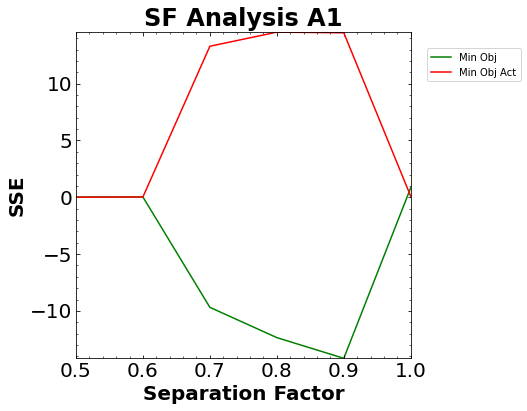

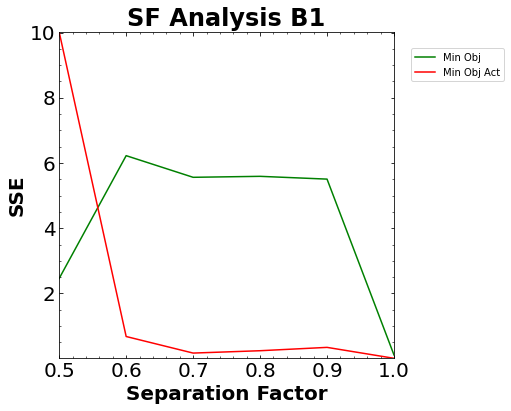

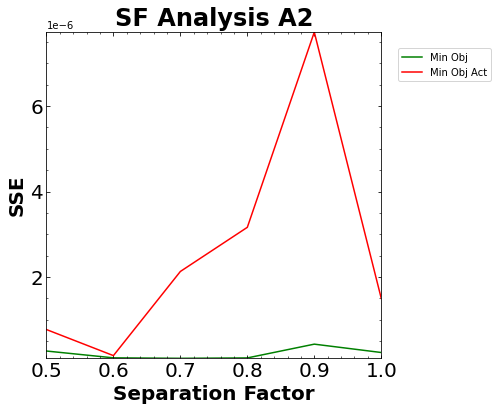

In [9]:
#Plot Sep Fact vs sse min
date_time_str = "2023/09/06/"
save_csv = False
name_cs_str = "CS1"      
bo_method = "A1"
bo_method_list = ["A1", "B1", "A2"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "Separation Factor"
y_label = "SSE"
save_path = None
data_true = None
log_data = False

data_true = theta_true

f = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
precision = 1
sep_fact_list = [f"{number:.{precision}f}" for number in f]

for bo_method in bo_method_list:
    title = "SF Analysis " + bo_method
    y_data, data_names = analyze_SF_data_for_plot(df, bo_method, f) #Use f for signac and sep_fact_list for signac
    # print(y_data)
    #Run Sep Fact Experiment Analysis (file_path)
    plot_SF_data(f, y_data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, 
                 other_fontsize, save_path)